# Required libraries

In [ ]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Data Analysis

In [ ]:
# reading the file
unprocessed_df = pd.read_csv("fires.csv")
unprocessed_df

In [ ]:
# statistical information about the data
unprocessed_df.describe()

In [ ]:
# some more detailed information about the data
unprocessed_df.info()

In [ ]:
unprocessed_df.isna().any()

In [ ]:
# getting counts of unique values for each column
for each_column in unprocessed_df.columns:
  print(unprocessed_df[each_column].value_counts())
  print("\n")

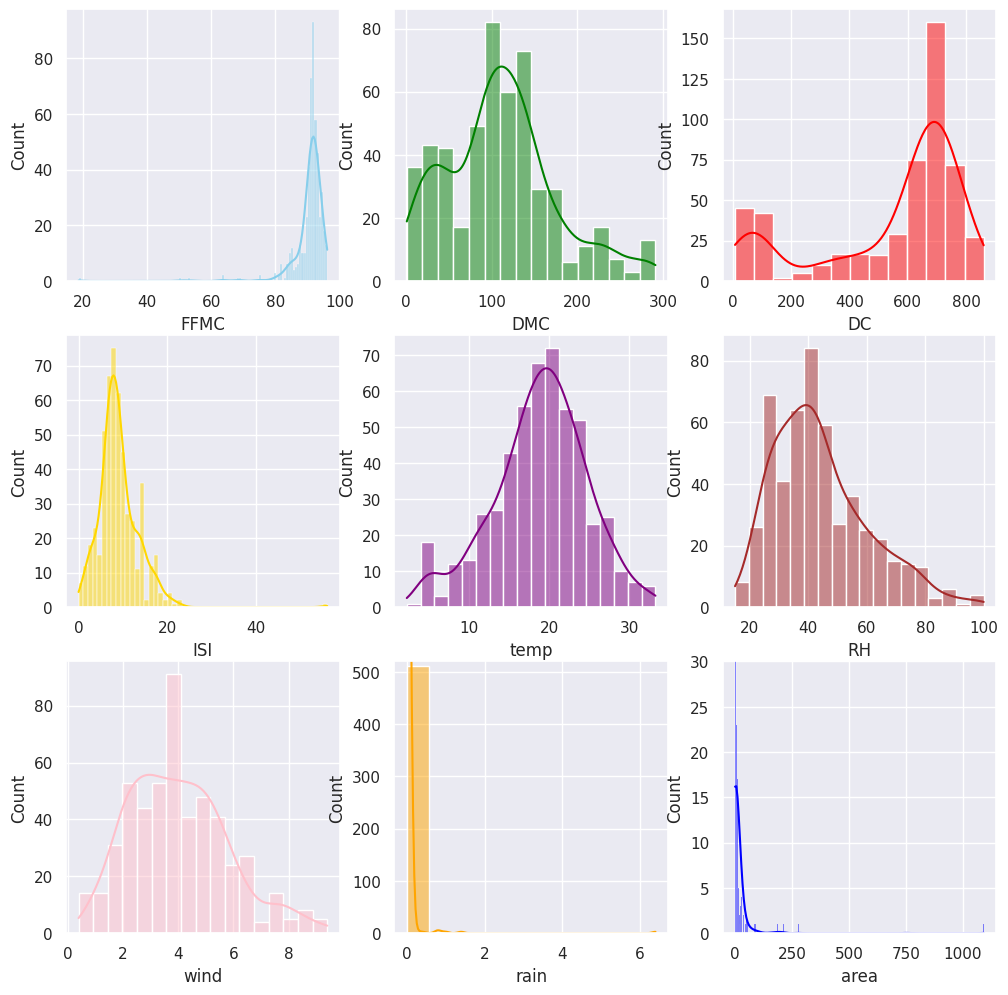

In [ ]:
# plotting the distribution of all features before processing
sns.set(style="darkgrid")

fig, axs = plt.subplots(3, 3, figsize=(12, 12))
axs[2,1].set_ylim(0,520)
axs[2,2].set_ylim(0,30)

sns.histplot(data=unprocessed_df, x="FFMC", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=unprocessed_df, x="DMC", kde=True, color="green", ax=axs[0, 1])
sns.histplot(data=unprocessed_df, x="DC", kde=True, color="red", ax=axs[0, 2])
sns.histplot(data=unprocessed_df, x="ISI", kde=True, color="gold", ax=axs[1, 0])
sns.histplot(data=unprocessed_df, x="temp", kde=True, color="purple", ax=axs[1, 1])
sns.histplot(data=unprocessed_df, x="RH", kde=True, color="brown", ax=axs[1, 2])
sns.histplot(data=unprocessed_df, x="wind", kde=True, color="pink", ax=axs[2, 0])
sns.histplot(data=unprocessed_df, x="rain", kde=True, color="orange", ax=axs[2, 1])
sns.histplot(data=unprocessed_df, x="area", kde=True, color="blue", ax=axs[2, 2])

plt.show()

# Feature Representation (categorical values to numerical values)

In [ ]:
unprocessed_df

In [ ]:
# converting categorical data to one-hot encoded representations
df_categorical_x = pd.get_dummies(unprocessed_df.X)
df_categorical_y = pd.get_dummies(unprocessed_df.Y)
df_categorical_month = pd.get_dummies(unprocessed_df.month)
df_categorical_day = pd.get_dummies(unprocessed_df.day)

display(df_categorical_x)
display(df_categorical_y)
display(df_categorical_month)
display(df_categorical_day)

In [ ]:
# renaming columns to remove some ambgiuity
df_categorical_x.columns = ['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9']
df_categorical_y.columns = ['y_2', 'y_3', 'y_4', 'y_5', 'y_6', 'y_8', 'y_9']

display(df_categorical_x)
display(df_categorical_y)

In [ ]:
unprocessed_df.drop(['X', 'Y', 'month', 'day'], axis=1, inplace=True)
unprocessed_df

In [ ]:
# replace and join the one-hot encoded columns with the rest of the columns
processed_df = pd.concat([unprocessed_df, df_categorical_x, df_categorical_y, df_categorical_month, df_categorical_day], axis=1)
processed_df

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,x_1,...,nov,oct,sep,fri,mon,sat,sun,thu,tue,wed
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00,0,...,0,0,0,1,0,0,0,0,0,0
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00,0,...,0,1,0,0,0,0,0,0,1,0
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00,0,...,0,1,0,0,0,1,0,0,0,0
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00,0,...,0,0,0,1,0,0,0,0,0,0
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44,0,...,0,0,0,0,0,0,1,0,0,0
513,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29,0,...,0,0,0,0,0,0,1,0,0,0
514,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16,0,...,0,0,0,0,0,0,1,0,0,0
515,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00,1,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
processed_df.columns

# Splitting data

In [ ]:
X = processed_df.drop('area', axis=1, inplace=False)
y = processed_df['area']

display(X)
display(y)

In [ ]:
# splitting 70% of the data into training data and 30% into testing data
seed = 4
ratio=0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= ratio, random_state= seed)

# Feature Normalization

In [ ]:
def normalize_x(X_train):

  X_train.update(X_train.iloc[:,1:3].apply(zscore))
  X_train.update(X_train.iloc[:,4:7].apply(zscore))

  X_train['FFMC'].clip(lower=70, inplace=True)
  X_train['ISI'].clip(upper=25, inplace=True)

  X_train.update(X_train.iloc[:,0:1].apply(zscore))
  X_train.update(X_train.iloc[:,3:4].apply(zscore))

  X_train["rain"] = np.log2(X_train["rain"]+1)

  return X_train

## X_train and X_test

In [ ]:
# Different normalization methods used on different columns as required:
# clipping- FFMC, ISI
# Zscore- DMC, DC, temp, RH, wind
# log- rain, area

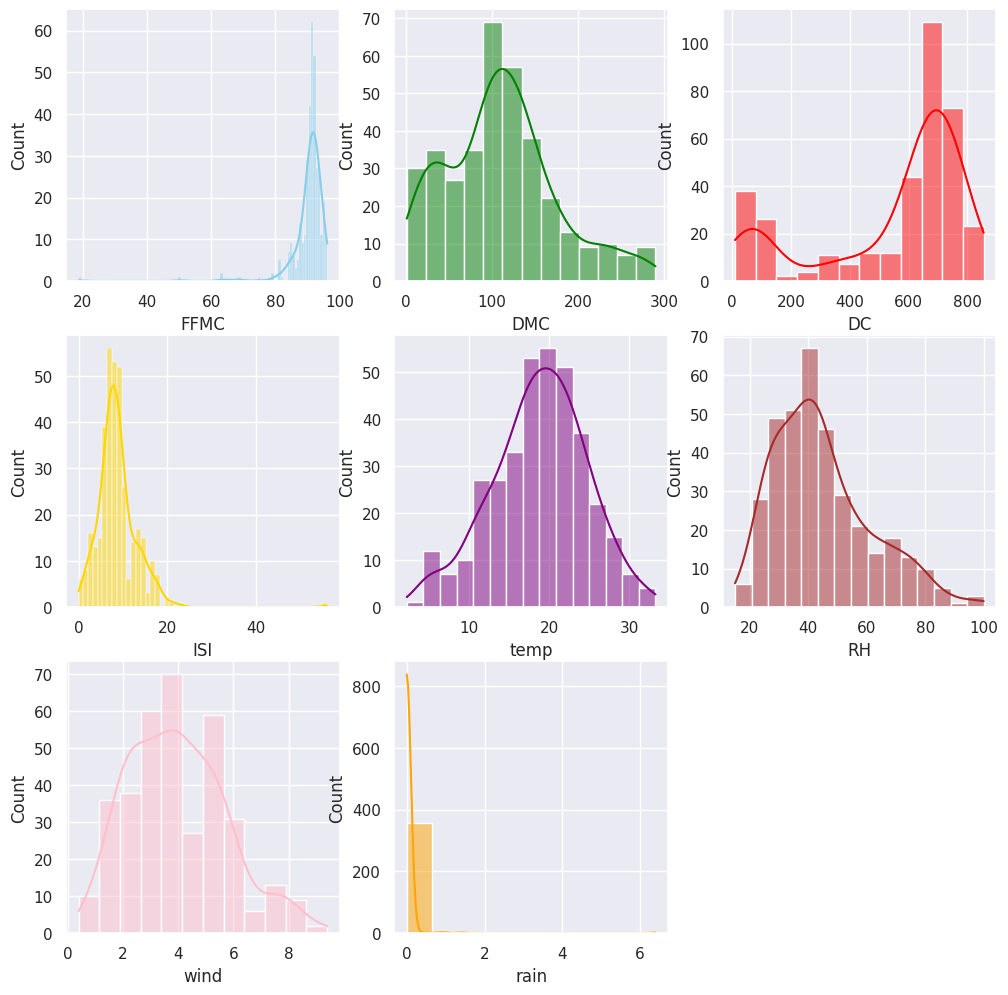

In [ ]:
# distribution of features of X_train before normalization
sns.set(style="darkgrid")

fig, axs = plt.subplots(3, 3, figsize=(12, 12))

sns.histplot(data=X_train, x="FFMC", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=X_train, x="DMC", kde=True, color="green", ax=axs[0, 1])
sns.histplot(data=X_train, x="DC", kde=True, color="red", ax=axs[0, 2])
sns.histplot(data=X_train, x="ISI", kde=True, color="gold", ax=axs[1, 0])
sns.histplot(data=X_train, x="temp", kde=True, color="purple", ax=axs[1, 1])
sns.histplot(data=X_train, x="RH", kde=True, color="brown", ax=axs[1, 2])
sns.histplot(data=X_train, x="wind", kde=True, color="pink", ax=axs[2, 0])
sns.histplot(data=X_train, x="rain", kde=True, color="orange", ax=axs[2, 1])
fig.delaxes(axs[2][2])


plt.show()

In [ ]:
# normalize X_train

X_train = normalize_x(X_train)

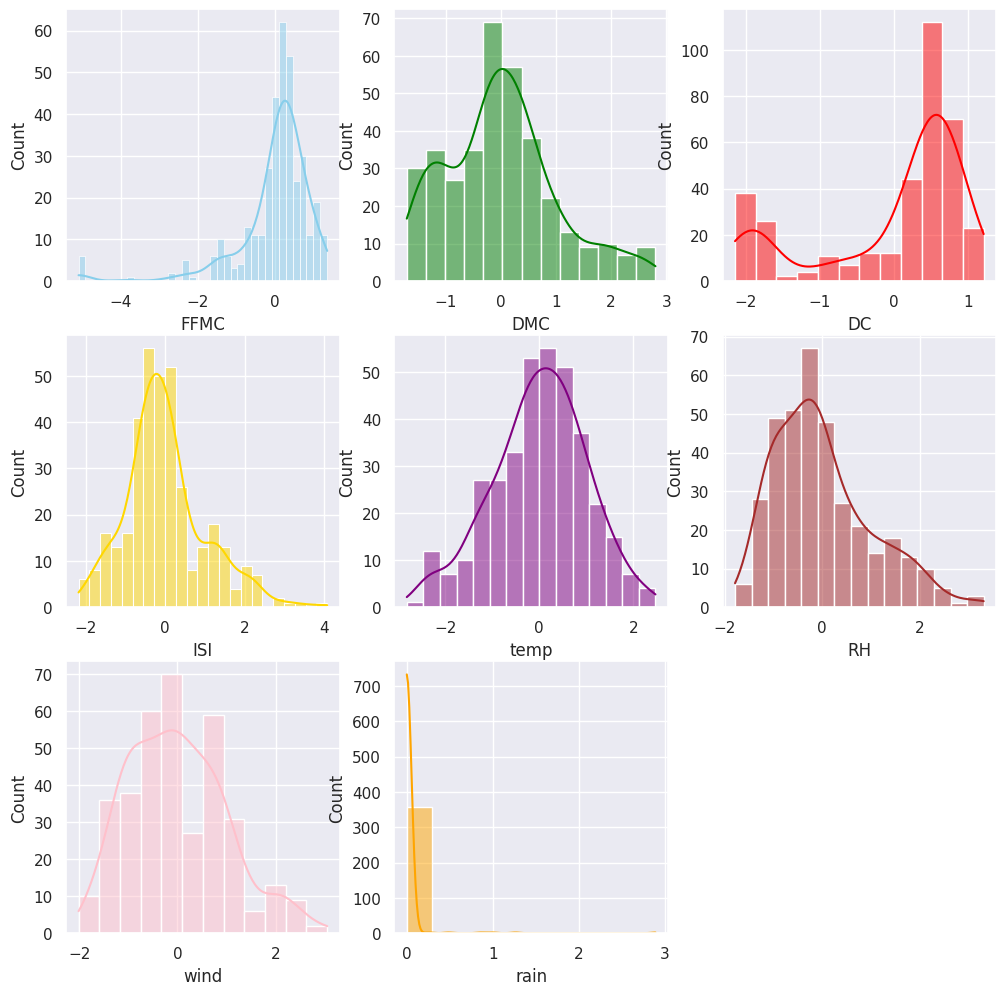

In [ ]:
# distribution of features of X_train after normalization

sns.set(style="darkgrid")

fig, axs = plt.subplots(3, 3, figsize=(12, 12))

sns.histplot(data=X_train, x="FFMC", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=X_train, x="DMC", kde=True, color="green", ax=axs[0, 1])
sns.histplot(data=X_train, x="DC", kde=True, color="red", ax=axs[0, 2])
sns.histplot(data=X_train, x="ISI", kde=True, color="gold", ax=axs[1, 0])
sns.histplot(data=X_train, x="temp", kde=True, color="purple", ax=axs[1, 1])
sns.histplot(data=X_train, x="RH", kde=True, color="brown", ax=axs[1, 2])
sns.histplot(data=X_train, x="wind", kde=True, color="pink", ax=axs[2, 0])
sns.histplot(data=X_train, x="rain", kde=True, color="orange", ax=axs[2, 1])
fig.delaxes(axs[2][2])

plt.show()

In [ ]:
# normalize X_test

X_test = normalize_x(X_test)

## y_train and y_test

In [ ]:
y_train = y_train.transform(lambda x: math.log2(1+x))
y_train

In [ ]:
y_test = y_test.transform(lambda x: math.log2(1+x))
y_test

# Model 1: Decision Tree

In [ ]:
mse_scores = []
mae_scores = []


## Decision Tree without hyperparameter tuning

In [ ]:
# decision tree without tuning hyperparameters, holdout testing
decision_tree_base = DecisionTreeRegressor()
decision_tree_base.fit(X_train, y_train)
y_pred = decision_tree_base.predict(X_test)

# evaluation
mse = metrics.mean_squared_error(y_test, y_pred)
print(f"Mean MSE: {mse}")
mse_scores.append(mse)

mae = metrics.mean_absolute_error(y_test, y_pred)
print(f"Mean MAE: {mae}")
mae_scores.append(mae)

In [ ]:
# plotting the non-optimized decision tree
plt.clf()

figure_tree = plt.figure(figsize=(50,50))
_ = tree.plot_tree(decision_tree_base, filled=True)

## Decision Tree with hyperparameter tuning

In [ ]:
# Defining the parameters to optimize and their values to choose from
parameters = {'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
              'splitter': ['best', 'random'],
              'max_depth': np.arange(1,50)}
decision_tree= GridSearchCV(DecisionTreeRegressor(), parameters)
decision_tree.fit(X_train, y_train)
print(decision_tree.best_params_)

y_pred = decision_tree.predict(X_test)

{'criterion': 'friedman_mse', 'max_depth': 2, 'splitter': 'random'}


In [ ]:
# evaluation
mse = metrics.mean_squared_error(y_test, y_pred)
print(f"Mean MSE: {mse}")
mse_scores.append(mse)

mae = metrics.mean_absolute_error(y_test, y_pred)
print(f"Mean MAE: {mae}")
mae_scores.append(mae)

<Figure size 640x480 with 0 Axes>

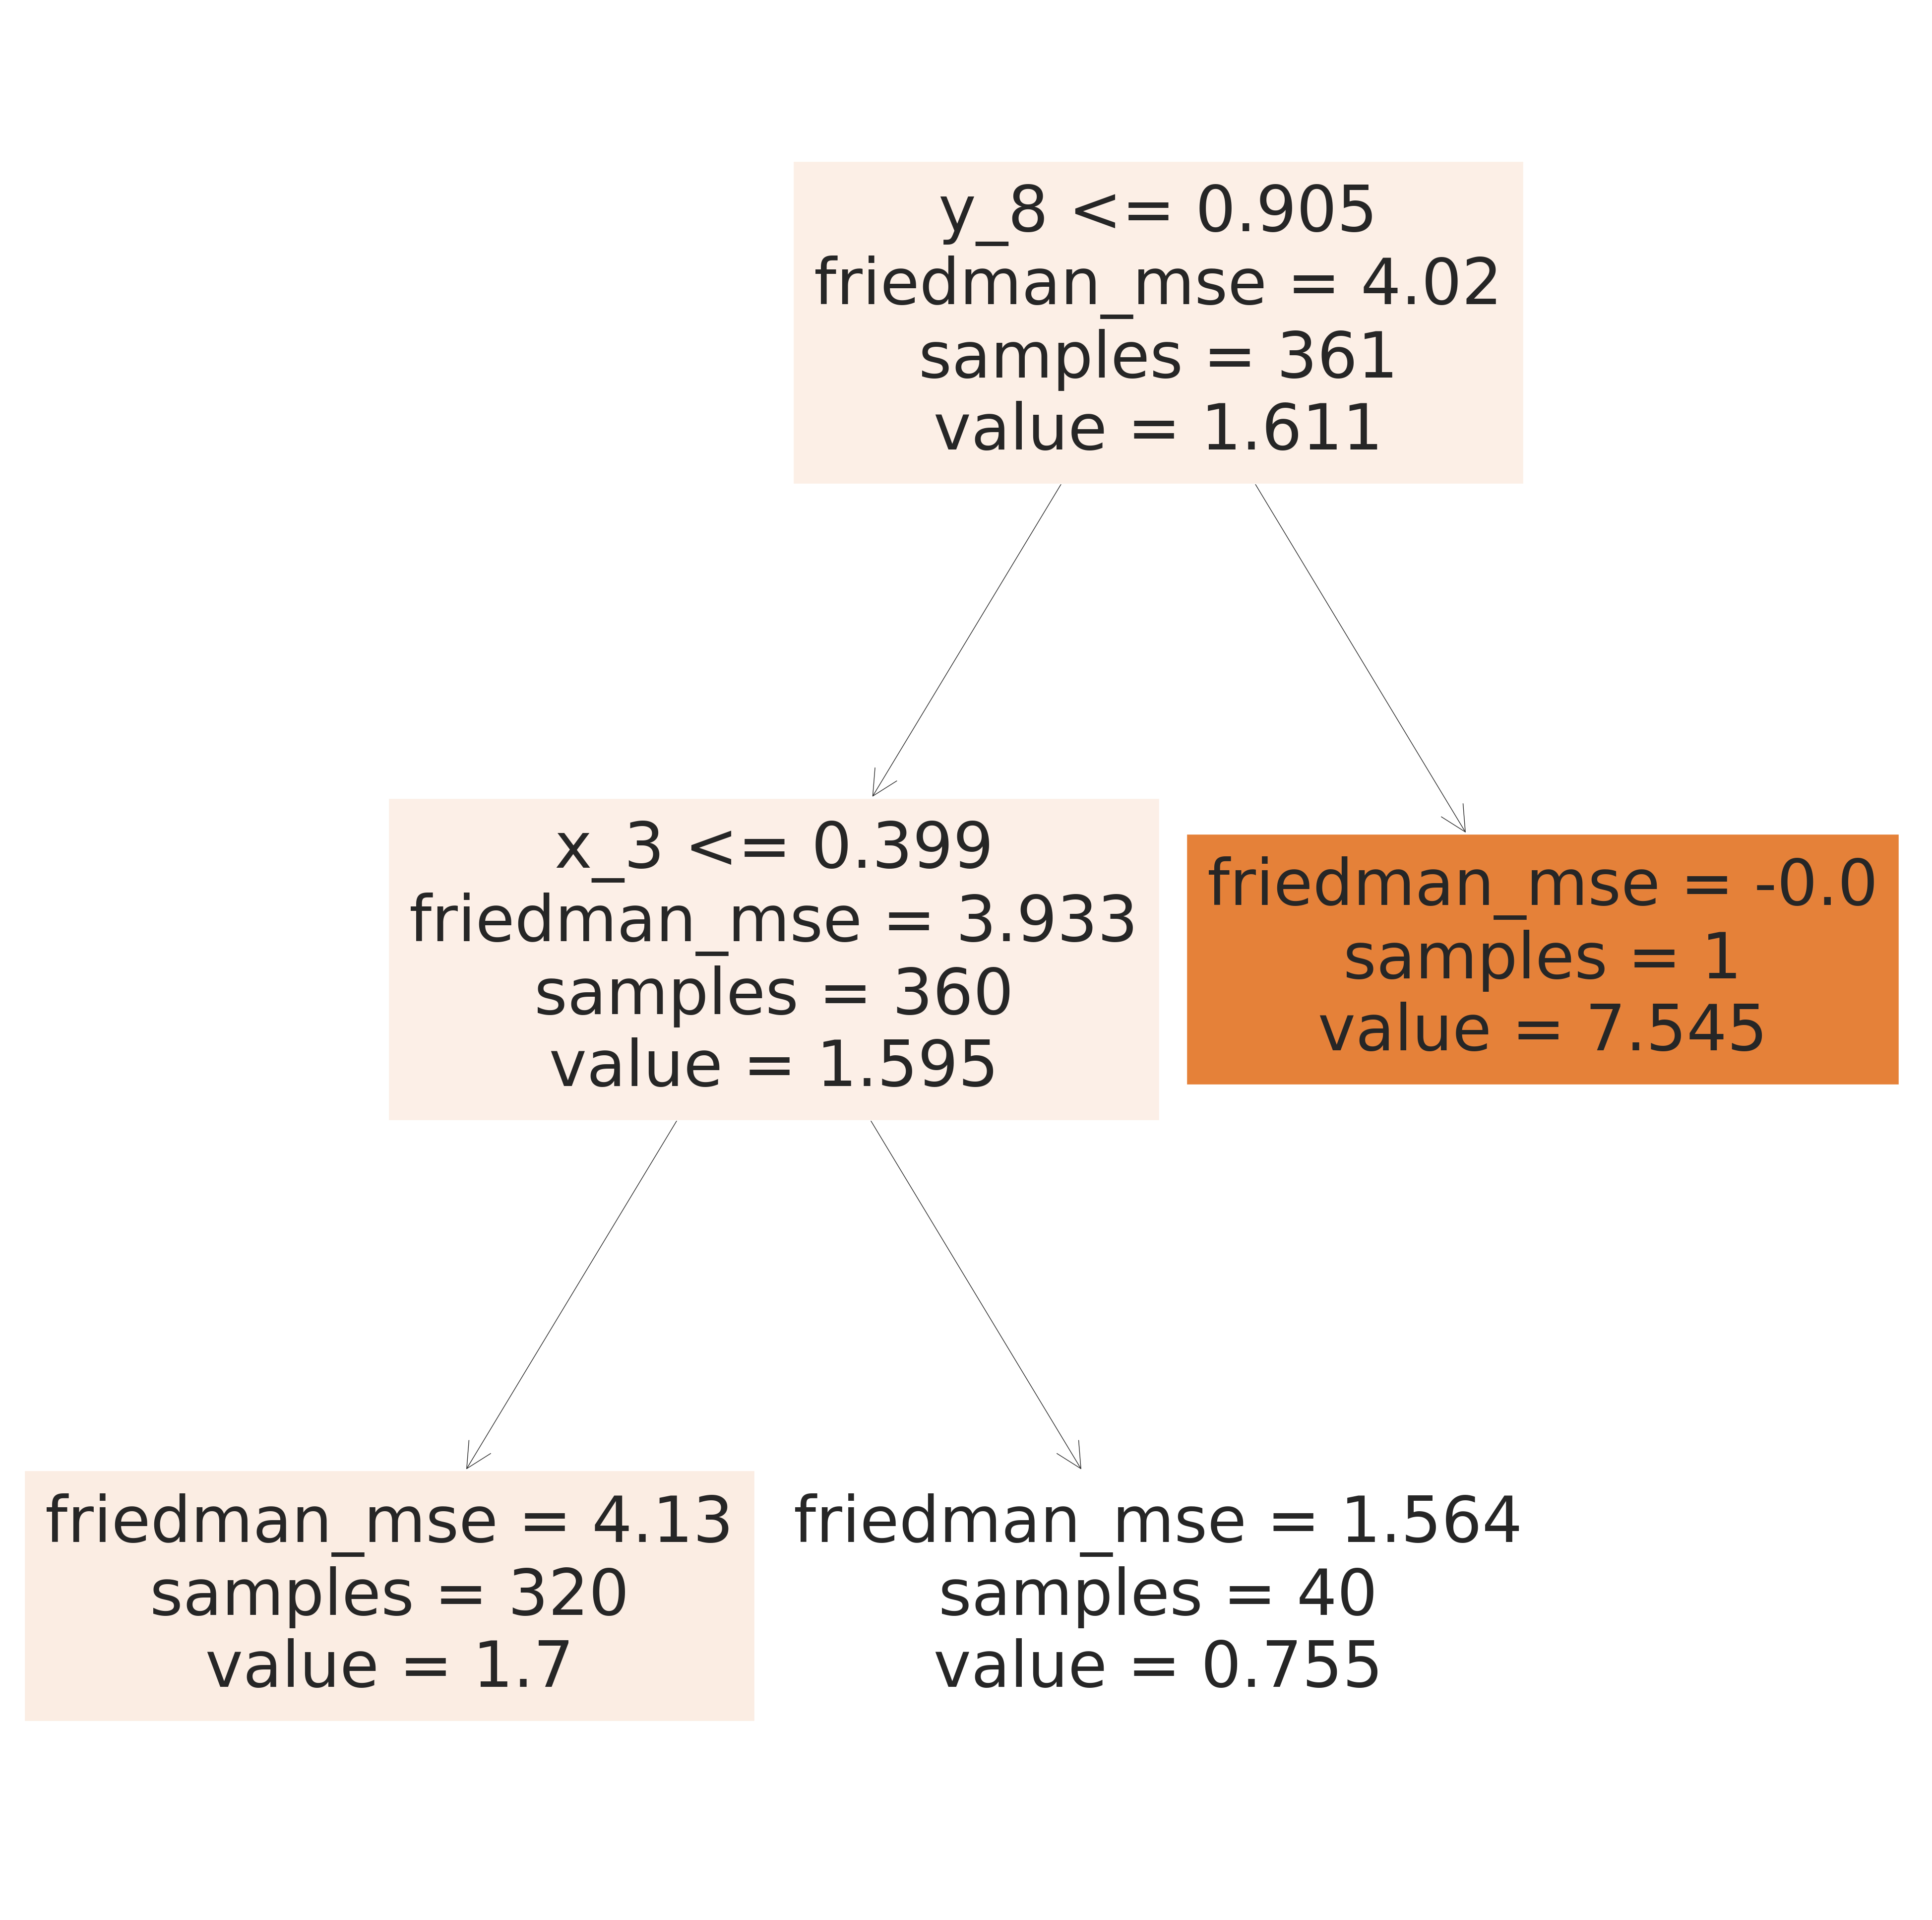

In [ ]:
# plotting the optimized decision tree

plt.clf()

figure_tree = plt.figure(figsize=(50,50))
_ = tree.plot_tree(decision_tree.best_estimator_, feature_names=X_train.columns, filled=True)


# Model 2: Linear Regression (Ridge)

In [ ]:
k_fold = KFold(n_splits=47, shuffle=True, random_state=4)

In [ ]:
mse_scores_lr = []
mae_scores_lr = []

# linear_regression = LinearRegression()
ridge_regression = Ridge()

# training model using k_fold validation and calculating mean squared error and mean absolute error

for train_index, test_index in k_fold.split(X):
    X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # normalizing data
    X_train = normalize_x(X_train)
    X_test = normalize_x(X_test)
    y_train = y_train.transform(lambda x: math.log2(1+x))
    y_test = y_test.transform(lambda x: math.log2(1+x))

    ridge_regression.fit(X_train, y_train)
    y_pred = ridge_regression.predict(X_test)

    intermediate_mse = metrics.mean_squared_error(y_test, y_pred)
    mse_scores_lr.append(intermediate_mse)

    intermediate_mae = metrics.mean_absolute_error(y_test, y_pred)
    mae_scores_lr.append(intermediate_mae)


In [ ]:
print(f"Mean MSE: {np.mean(mse_scores_lr)}")
mse_scores.append(np.mean(mse_scores_lr))

print(f"Mean MAE: {np.mean(mae_scores_lr)}")
mae_scores.append(np.mean(mae_scores_lr))

# Model comparison

In [ ]:
# comparing non-optimized decision tree, optimized decision tree and ridge regression method
all_scores = {'MSE scores': mse_scores,'MAE scores': mae_scores}
all_models = ['Decision Tree','Optimized DT','Ridge Regression']
df_comparison = pd.DataFrame(data=all_scores,index=all_models)
df_comparison

<Axes: >

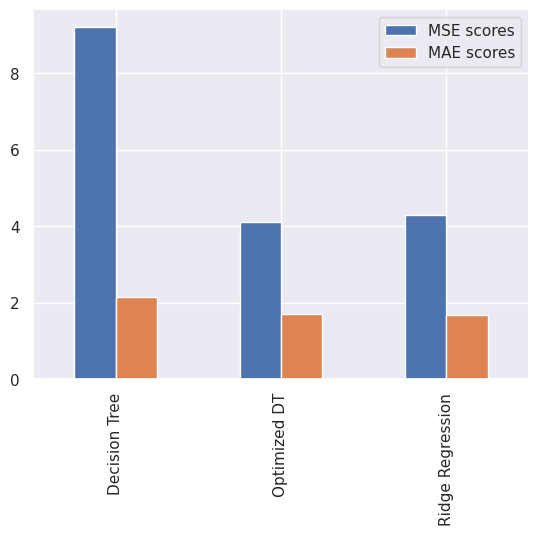

In [ ]:
df_comparison.plot(kind='bar')